In [1]:
###########################################################################
# This notebook is authored by: Ayan Paul                                 #
# Date: January 2021                                                      #
# If you use this code or the results from this work please cite:         # 
# Emergence of universality in the transmission dynamics of COVID-19      #
# Ayan Paul, Jayanta Kumar Bhattacharjee, Aksay Pal and Sagar Chakraborty #
# arXiv:2101.12556 (https://arxiv.org/abs/2101.12556)                     # 
###########################################################################

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests

# links to the JHU GitHub
jhu_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
jhu_confirmed_US = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

# links to RKI data source
incidence_data = 'https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv'
landkreis_data = 'https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv'

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#121212'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
rc('font',**{'family':'serif','serif':['New Century Schoolbook']})

In [2]:
def makeTSPlots(df, countries, plt, startdate, enddate, diff=True):
    ''' A function to make the plots for the time series
    arguments:
        df: the data frame with the time series data
        countries: the countries and states for which the data will be plot in a single plot
        plt: the matplotlib object
        startdate: the start date for the time series
        enddate: the end date for the time series
        diff: a flag to turn on taking the diff (for daily case rate) or not (for total number of cases) [default:True]
    returns:
        plt: the matplotlib object
    '''
    for c in countries:
        N_max = ((df[df['Country/Region']==c].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().diff().dropna()[-1]
        if diff: 
            df_TS = np.round(((df[df['Country/Region']==c].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().diff().dropna())
        else:
            df_TS = np.round(((df[df['Country/Region']==c].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().dropna())
        df_TS.index = pd.to_datetime(df_TS.index)
        df_TS = df_TS[startdate:enddate]

        df_TS.plot(linewidth=2)
    return plt

In [3]:
# Get the JHU data and note that Australia needs special aggregation
confirmed = pd.read_csv(jhu_confirmed)
confirmed_australia = confirmed[confirmed['Country/Region'] == 'Australia'].groupby('Country/Region', as_index=False).aggregate('sum')

# The time series data for the countries
countries = pd.DataFrame()
countries = confirmed[confirmed['Country/Region'] == 'Japan']
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'New Zealand']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Ireland']])
countries = pd.concat([countries, confirmed_australia])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Slovakia']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'United Kingdom'][confirmed['Province/State'].isna()]])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Germany']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'France'][confirmed['Province/State'].isna()]])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Italy']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Netherlands'][confirmed['Province/State'].isna()]])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Spain']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Korea, South']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Qatar']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'US']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'South Africa']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Turkey']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'Russia']])
countries = pd.concat([countries, confirmed[confirmed['Country/Region'] == 'India']])
countries = countries.drop(['Province/State'], axis=1)

# Rename some countries
countries.at[countries[countries['Country/Region']=='United Kingdom'].index[0], 'Country/Region'] = 'UK'
countries.at[countries[countries['Country/Region']=='Korea, South'].index[0], 'Country/Region'] = 'South Korea'

In [4]:
# The timeseries database
r = requests.get(incidence_data, params={"url_only": True})
j = r.json()
rki_df = pd.read_csv(j["url"])

# # This database is used to get the population data
r = requests.get(landkreis_data, params={"url_only": True})
j = r.json()
lk_df = pd.read_csv(j["url"])

# Pivoting the data to the correct format and the adding the population to it
rki_df['Meldedatum_datetime'] = pd.to_datetime(rki_df['Meldedatum'])
rki_df['Meldedatum_datetime'] = rki_df['Meldedatum_datetime'].dt.date
rki_pivot = pd.pivot_table(rki_df, values='AnzahlFall', index=['Bundesland', 'Landkreis'], columns=['Meldedatum_datetime'], aggfunc=np.sum, fill_value=0)
rki_pivot.reset_index(inplace=True)
lk_df.rename(columns = {'county': 'Landkreis', 'EWZ': 'population'}, inplace = True)
rki_pivot_population = pd.merge(lk_df[['Landkreis', 'population']], rki_pivot, how='inner', on='Landkreis')

# Merge LK and SK (Google does not provide corresponding data)
# Deal with Berlin because RKI reports too many subdivisions which are difficult to match with Google
# Add country to the mix
rki_pivot_population['Landkreis'] = rki_pivot_population['Landkreis'].str.replace('[SL]K ', '', regex=True)
rki_grouped = rki_pivot_population.groupby(by=['Bundesland','Landkreis']).sum()
rki_grouped.reset_index(inplace=True)
berlin_aggregate = rki_grouped[rki_grouped['Landkreis'].str.contains('Berlin')].sum()
berlin_aggregate.loc['Landkreis'] = 'Berlin'
berlin_aggregate.loc['Bundesland'] = 'Berlin'
rki_grouped = rki_grouped[~rki_grouped['Landkreis'].str.contains('Berlin')].append(berlin_aggregate, ignore_index=True)
rki_grouped.insert(0,'country', "Germany")

# Final dataframe that will be processed
df_covid19_Germany = rki_grouped.copy(deep=True)
df_covid19_Germany.rename(columns = {'Bundesland': 'admin1', 'Landkreis': 'admin2'}, inplace = True)
df_Germany = df_covid19_Germany.drop('country', axis=1).rename(columns={'admin1': 'Country/Region', 'admin2': 'Lat', 'population': 'Long'})
df_Germany['Lat'] = 0
df_Germany['Long'] = 0
df_Germany = df_Germany.groupby('Country/Region', as_index=False).sum()
idx = pd.date_range(countries.columns[3], countries.columns[-1])
df_tmp = ((df_Germany.iloc[:, 3:].T).reindex(idx, fill_value=0)).T
df_tmp.columns = df_tmp.columns.map(lambda t: t.strftime('%m/%d/%y').lstrip("0").replace("/0", "/"))
df_Germany = pd.concat([df_Germany.iloc[:, :3], df_tmp], axis=1)
df_Germany = pd.concat([df_Germany.iloc[:, :3], df_Germany.iloc[:, 3:].cumsum(axis=1)], axis=1)

# Some selected states of Germany
countries = pd.concat([countries, df_Germany[df_Germany['Country/Region'] == 'Hamburg']])
countries = pd.concat([countries, df_Germany[df_Germany['Country/Region'] == 'Berlin']])
countries = pd.concat([countries, df_Germany[df_Germany['Country/Region'] == 'Bayern']])
countries = pd.concat([countries, df_Germany[df_Germany['Country/Region'] == 'Nordrhein-Westfalen']])
countries = pd.concat([countries, df_Germany[df_Germany['Country/Region'] == 'Baden-Württemberg']])

In [5]:
# Time series data for the United States
confirmed_US = pd.read_csv(jhu_confirmed_US)
confirmed_US = confirmed_US.iloc[:, 6:].drop(columns=['Country_Region', 'Combined_Key']).groupby('Province_State', as_index=False).sum()
confirmed_US.rename(columns={'Province_State': 'Country/Region', 'Long_': 'Long'}, inplace=True)

# Time series data for some seledted states of the US
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'New York']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'California']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Texas']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Arizona']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Illinois']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Florida']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Ohio']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Georgia']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Michigan']])
countries = pd.concat([countries, confirmed_US[confirmed_US['Country/Region'] == 'Washington']])

In [6]:
# Save all the data to a csv for later use
countries.to_csv('data/countries.csv')

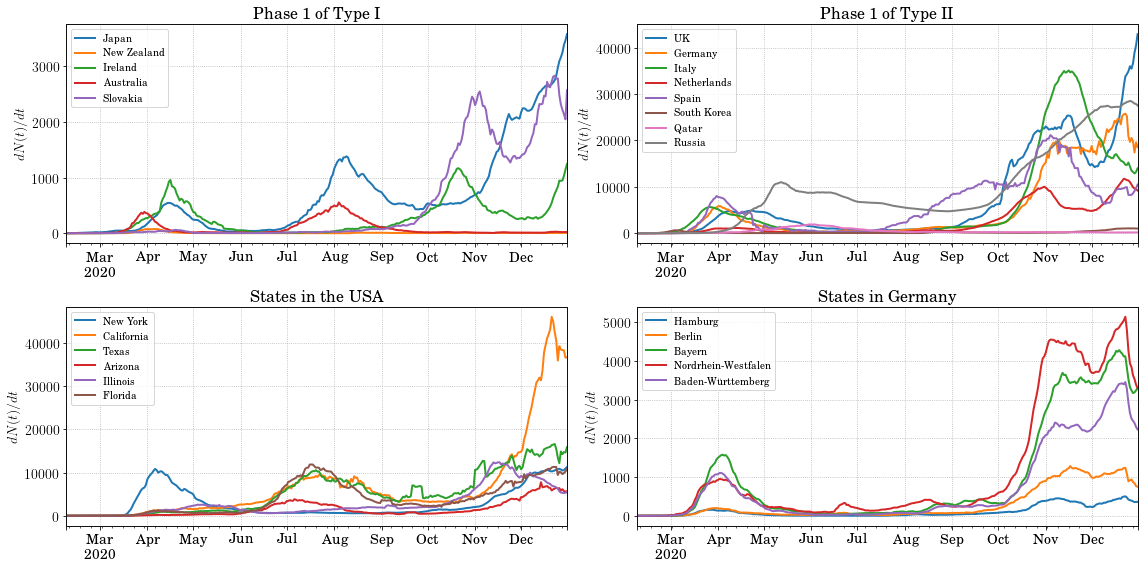

In [8]:
# Make the plots
window_size = 7
countries_1 = ['Japan', 'New Zealand', 'Ireland', 'Australia', 'Slovakia']
countries_2 = ['UK','Germany', 'Italy', 'Netherlands', 'Spain', 'South Korea', 'Qatar', 'Russia']
countries_3 = ['New York','California', 'Texas', 'Arizona', 'Illinois', 'Florida']
countries_4 = ['Hamburg','Berlin', 'Bayern', 'Nordrhein-Westfalen', 'Baden-Württemberg']
startdate = '2020-2-8'
enddate = '2020-12-31'
t1_2 = 52
datet1_2 = str(datetime.datetime.strptime(startdate, '%Y-%m-%d') + datetime.timedelta(days=t1_2))[:10]

fig = plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt = makeTSPlots(countries, countries_1, plt, startdate, enddate, True)
plt.ylabel(r'$dN(t)/dt$', fontsize=14)
plt.title('Phase 1 of Type I', fontsize=16)
plt.legend(countries_1, loc='upper left')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.grid()

plt.subplot(2,2,2)
plt = makeTSPlots(countries, countries_2, plt, startdate, enddate, True)
plt.ylabel(r'$dN(t)/dt$', fontsize=14)
plt.title('Phase 1 of Type II', fontsize=16)
plt.legend(countries_2, loc='upper left')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.grid()

plt.subplot(2,2,3)
plt = makeTSPlots(countries, countries_3, plt, startdate, enddate, True)
plt.ylabel(r'$dN(t)/dt$', fontsize=14)
plt.title('States in the USA', fontsize=16)
plt.legend(countries_3, loc='upper left')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.grid()

plt.subplot(2,2,4)
plt = makeTSPlots(countries, countries_4, plt, startdate, enddate, True)
plt.ylabel(r'$dN(t)/dt$', fontsize=14)
plt.title('States in Germany', fontsize=16)
plt.legend(countries_4, loc='upper left')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.grid()

plt.tight_layout()
plt.savefig('../plots/TimeSeries.pdf', dpi=300, facecolor='white')
plt.show()